# Introduction
* Hello, my name is Geary
* This is a project detailing the process undertaken to predict the cases of `Fraud` (Class)

## Project Objective 
> Document code, process data (through entire pipeline), and articulate key findings and takeways
* Create modules that faciliate project repeatability, as well as final report readability
> Ask/Answer exploratory questions of data and attributes to understand drivers of home value  
* Utilize charts and statistical tests
> Construct models to predict `Fraud` using classification modeling techniques and Feature Engineering</br>  
> Make recommendations

## Project Business Goals
> Construct ML Classification model that accurately predicts `Fraud`
* `Fraud` = Class </br>
> Find key features of `Fraud`</br>
> Deliver report that the data science team can read through and replicate  
> Share steps were taken, why and what the outcome was.
> Make recommendations on what works or doesn't work in predicting `Fraud`

### Executive Summary
* Relied on clustering and anomoly detection for bulk of feature differientation to predict `Fraud`
* Feature sets informed by the combination of Feature Engineering and Clustering/Anomoly detection
* Model gain on predictive performance vs. baseline prediction was minimal on test set (still was able to reduce by 50%!)

In [1]:
##imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import plotly.express as px

from pydataset import data
from scipy import stats
import statistics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix,recall_score,precision_score,accuracy_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.feature_selection import RFE, SelectKBest, f_regression

from wrangle import *
from explore import *
from modeling import *

import warnings
warnings.filterwarnings("ignore")


## Wrangle (Acquire and Prep)
> Look for csv, Feature Names are unknown to protect confidentiality
> Returns a dataframe that is cleaned from source (Kaggle): 
* Feature Engineering
> Features:
- `Cluster V-030409`: Clusters of features from V03,V04,V09
- `Cluster V-101112`: Clusters of features from V10,V11,V12 
- `Cluster V-141617`: Clusters of features from V14,V16,V17
- `if1_anom`: Anomoly Prediction results from IsolationForest  
- `Indicate`: Features indicated by RFE to be related to our target `Fraud`  
> Split:  
- Train: 60%  
- Validate: 20%  
- Test: 20%  
> Scaled:  
- MinMaxScaler(): Used for cluster engineering and modeling  
> Summary  
- Visualized distinctions within the data to inform exploratory analysis  
    

In [2]:
df, target, train, train_scaled, validate, validate_scaled, test, test_scaled, cluster_list, indicate = wrangle_creditcard()

(170883, 32) (56962, 32) (56962, 32)
-----
DataFrame info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 32 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Time      284807 non-null  float64
 1   V1        284807 non-null  float64
 2   V2        284807 non-null  float64
 3   V3        284807 non-null  float64
 4   V4        284807 non-null  float64
 5   V5        284807 non-null  float64
 6   V6        284807 non-null  float64
 7   V7        284807 non-null  float64
 8   V8        284807 non-null  float64
 9   V9        284807 non-null  float64
 10  V10       284807 non-null  float64
 11  V11       284807 non-null  float64
 12  V12       284807 non-null  float64
 13  V13       284807 non-null  float64
 14  V14       284807 non-null  float64
 15  V15       284807 non-null  float64
 16  V16       284807 non-null  float64
 17  V17       284807 non-null  float64
 18  V18       284807 non-nul

# Exploration
- Initial phase - Guidance

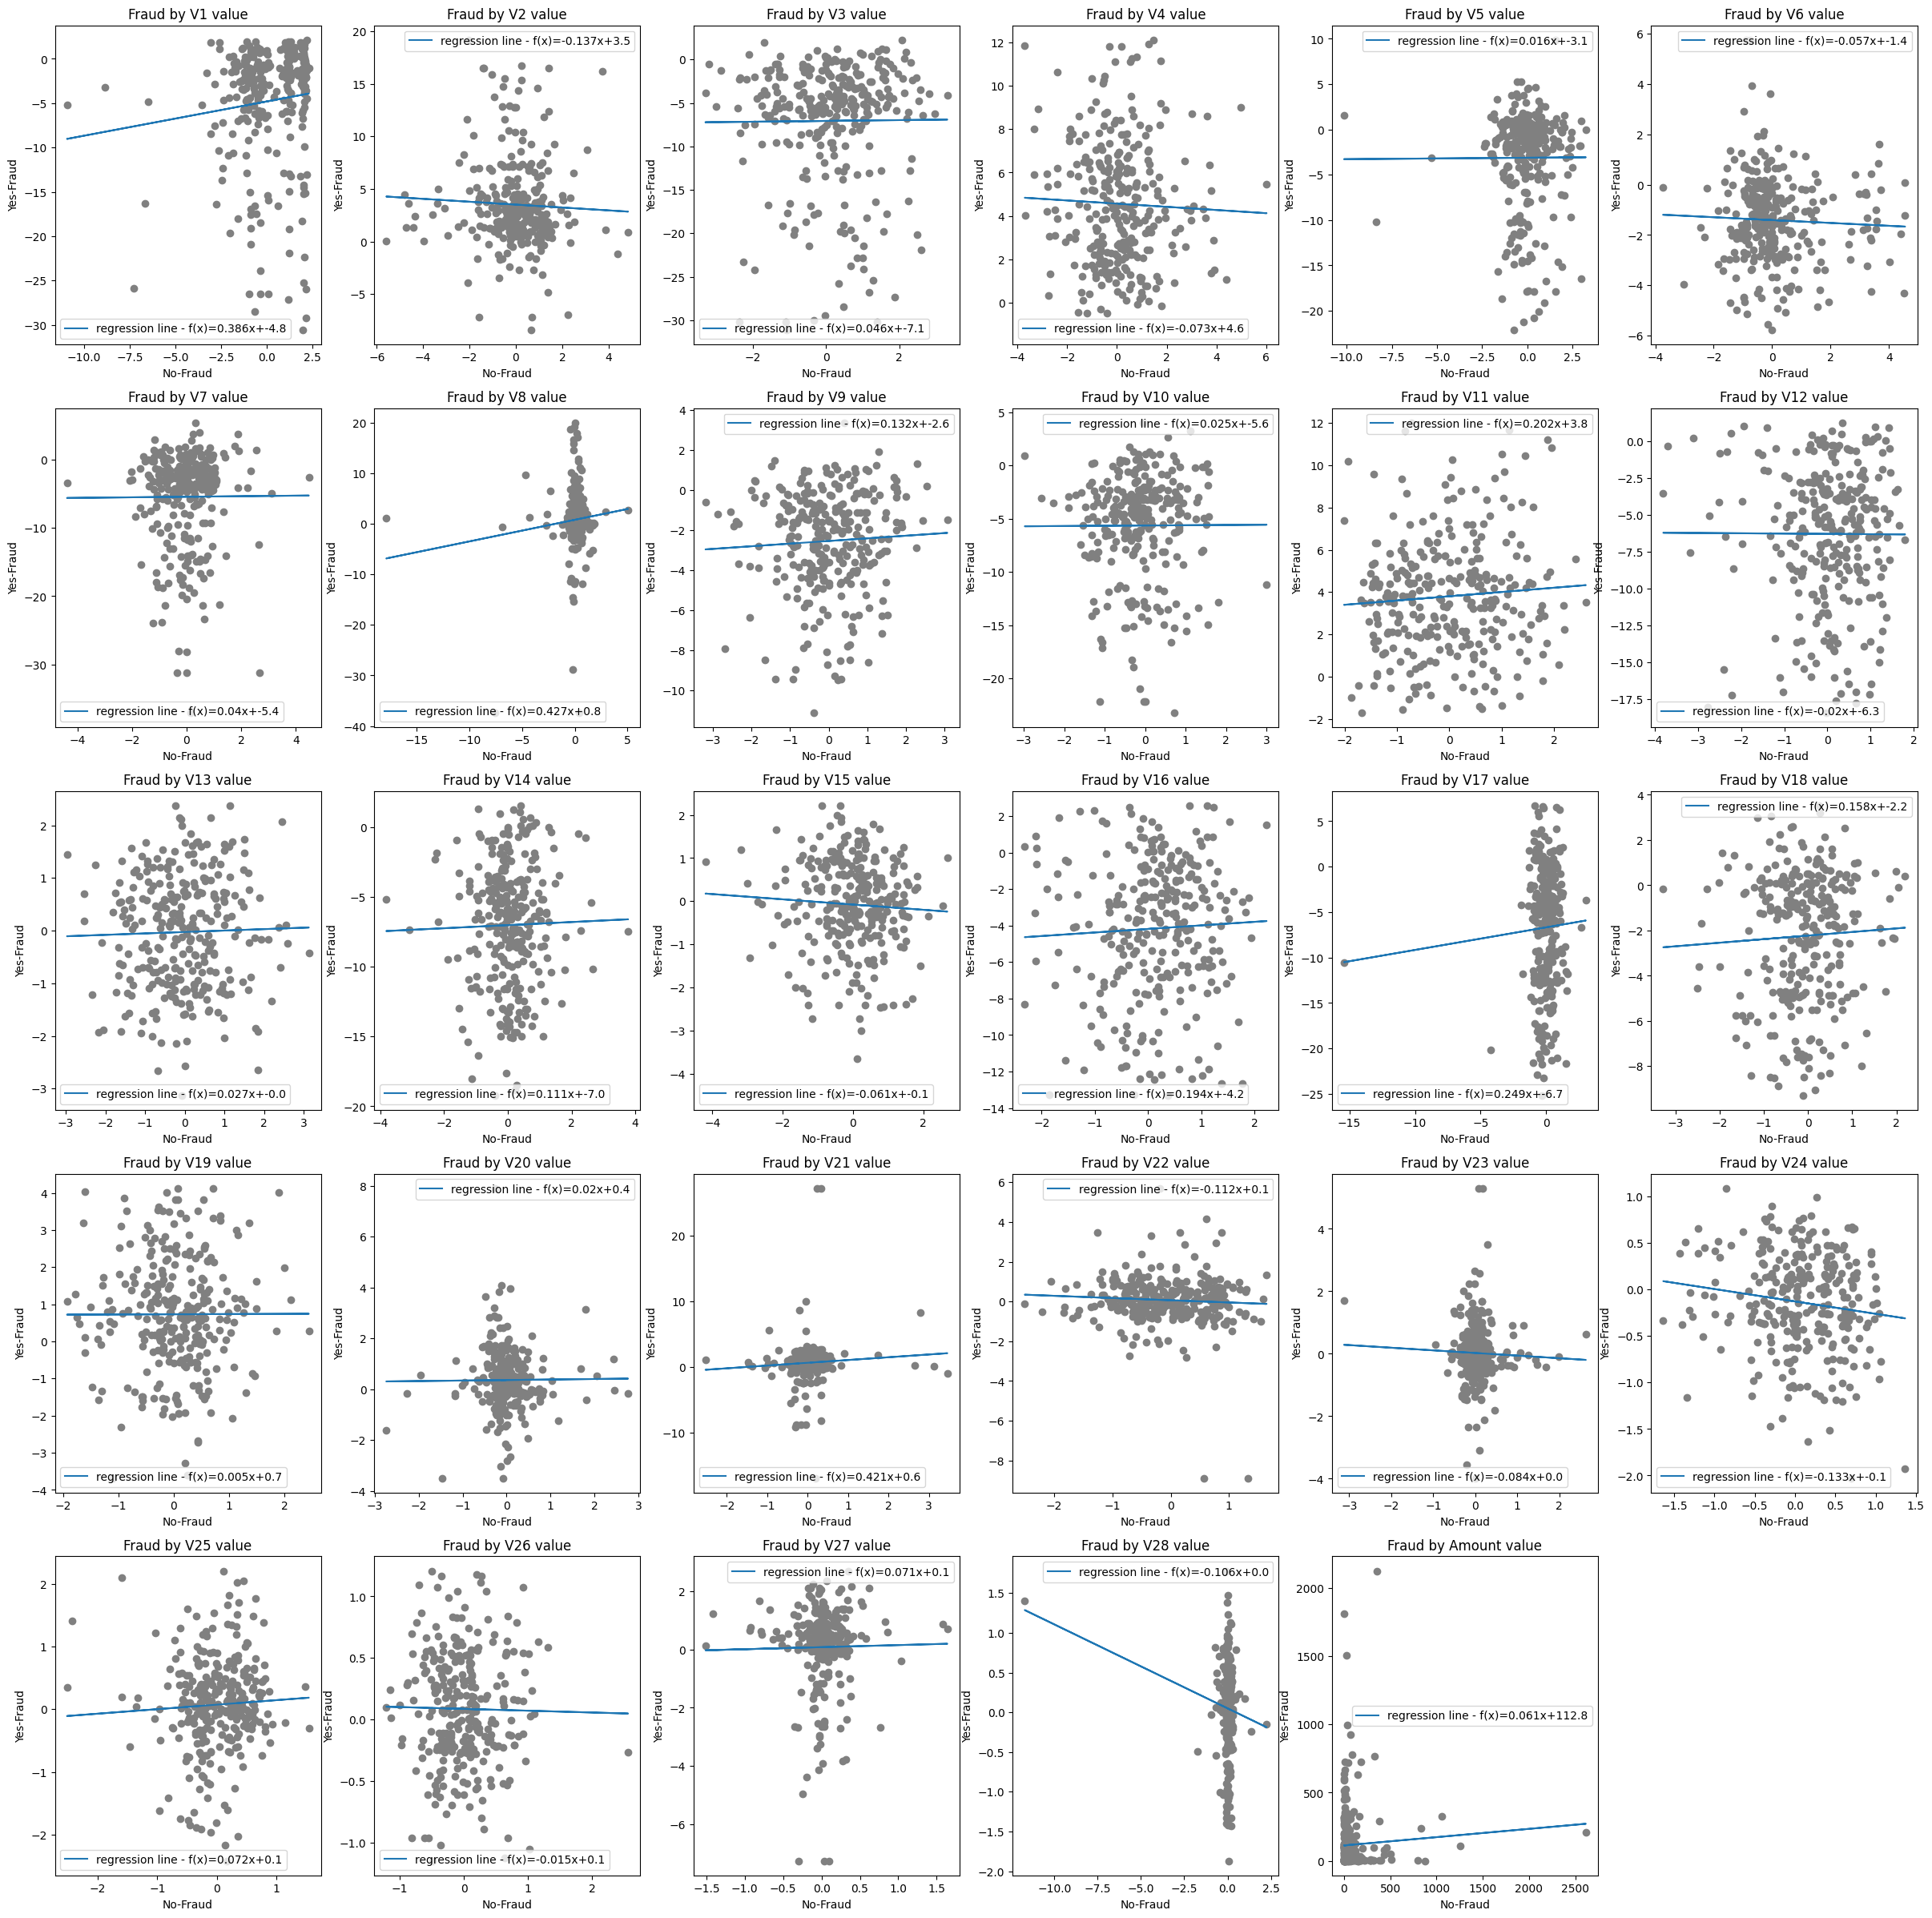

In [3]:
correlation_guidance(train,target)

### Takeaway 
- So we're looking for narrow spreads, this indicated that the majority of information that falls into one class (fraud or no fraud) is unlikey to fall into the other (see V20,V23,V28, if a window was created at approx. +/- 0.5 there would be a decent capture of Fraud and not so much of No Fraud (precision vs recall))

let's ask some questions of our observations from above


##  **Hypothesis 1 - Do the sample means of V20, V23, and V28 vary for Yes-Fraud compared to the population?**
> - alpha = .05
> - $H_0$: The mean values of `V20,V23,V28` for the sample `Yes-Fraud` will not be signifcantly different, to the population of `Fraud`.  
> - $H_a$: Rejection of Null ~~The mean values of `V20,V23,V28` for `Yes-Fraud` will not be signifcantly different, to the population of `Fraud`.~~  

>Conclusion: There is enough evidence to reject our null hypothesis only for V20


V20 <-target | Fraud <-population name | Yes-Fraud <-sample name
We reject the null Hypothesis ( Y̶e̶s̶-̶F̶r̶a̶u̶d̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶m̶e̶a̶n̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶F̶r̶a̶u̶d̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶V̶2̶0̶ ) t=5.29349, p=0.00000
----------
V23 <-target | Fraud <-population name | Yes-Fraud <-sample name
We fail to reject the null hypothesis ( Yes-Fraud as a sample has equal mean values to Fraud as a population regarding V23 ) t=0.43614, p=0.66306
----------
V28 <-target | Fraud <-population name | Yes-Fraud <-sample name
We fail to reject the null hypothesis ( Yes-Fraud as a sample has equal mean values to Fraud as a population regarding V28 ) t=1.60840, p=0.10882
----------


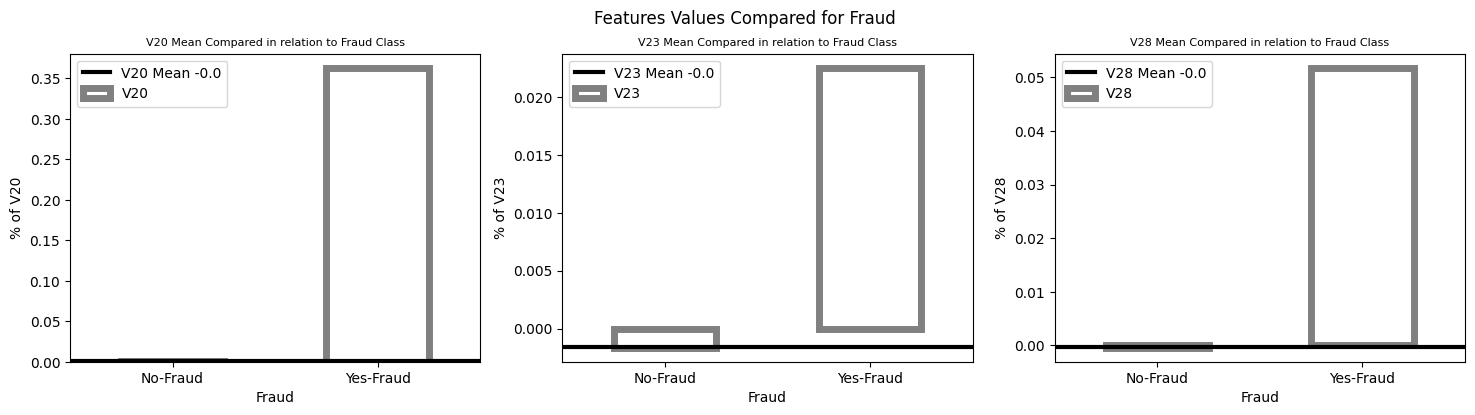

In [4]:
ttest_V_features(train)

### Takeaway 
- So we see from our test that the feature V20 does hold significance, while the features V23 and V28 do not yield meaningful results in helping us determine our target of Fraud

let's ask some questions of the clusters and feature's engineered


##  **Hypothesis 2 - Is the distribution of Fraud equal in all Cluster groups?**
> - alpha = .05
> - $H_0$: `Fraud` is not different in the distribution of `Cluster` Groups. 
> - $H_a$: Rejection of Null ~~`Fraud` is not different in the distribution of `Cluster` Groups~~

> Conclusion: There is enough evidence to reject our null hypothesis for all cases

Observed
[[11356 22579 82069 54584]
 [  236     1    52     6]]
---
Expected
[[1.15719884e+04 2.25410195e+04 8.19792323e+04 5.44957598e+04]
 [2.00115869e+01 3.89804720e+01 1.41767730e+02 9.42402111e+01]]
---
chi^2 = 2512.0052, p = 0.00000, degf = 3
due to p = 0.00000 < α = 0.05 we reject our null hypothesis
(  F̶r̶a̶u̶d̶ ̶i̶s̶ ̶n̶o̶t̶ ̶d̶i̶f̶f̶e̶r̶e̶n̶t̶ ̶i̶n̶ ̶t̶h̶e̶ ̶d̶i̶s̶t̶r̶i̶b̶u̶t̶i̶o̶n̶ ̶o̶f̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶V̶-̶0̶3̶0̶4̶0̶9̶ )


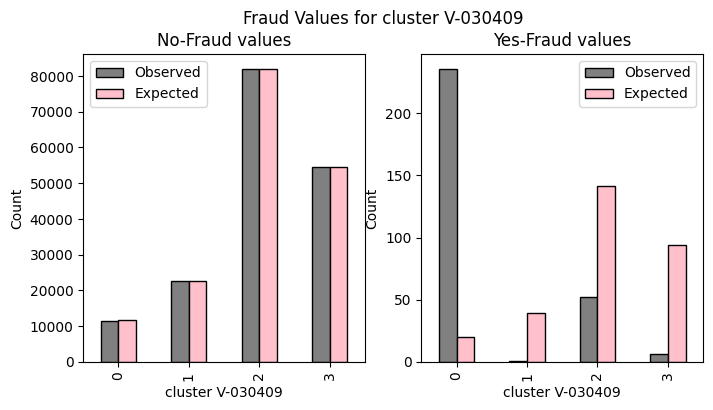

Observed
[[47932 61223 12157 49276]
 [   17    15   250    13]]
---
Expected
[[4.78662243e+04 6.11322832e+04 1.23855815e+04 4.92039111e+04]
 [8.27756711e+01 1.05716835e+02 2.14185437e+01 8.50889497e+01]]
---
chi^2 = 2635.1872, p = 0.00000, degf = 3
due to p = 0.00000 < α = 0.05 we reject our null hypothesis
(  F̶r̶a̶u̶d̶ ̶i̶s̶ ̶n̶o̶t̶ ̶d̶i̶f̶f̶e̶r̶e̶n̶t̶ ̶i̶n̶ ̶t̶h̶e̶ ̶d̶i̶s̶t̶r̶i̶b̶u̶t̶i̶o̶n̶ ̶o̶f̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶V̶-̶1̶0̶1̶1̶1̶2̶ )


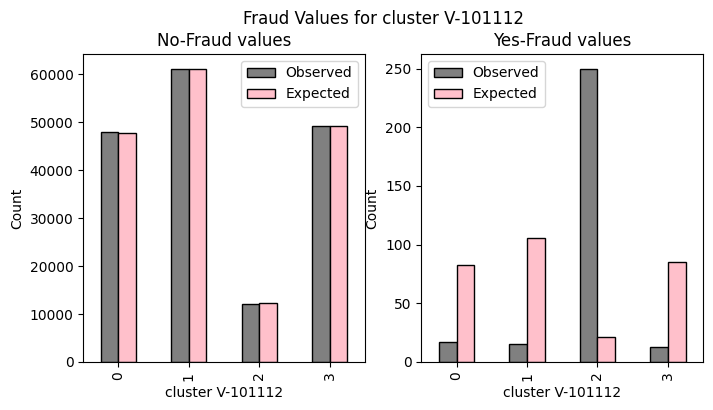

Observed
[[85619 28672 56268    29]
 [    7    72    57   159]]
---
Expected
[[8.54781815e+04 2.86943784e+04 5.62277646e+04 1.87675450e+02]
 [1.47818507e+02 4.96215539e+01 9.72353891e+01 3.24549546e-01]]
---
chi^2 = 77873.3075, p = 0.00000, degf = 3
due to p = 0.00000 < α = 0.05 we reject our null hypothesis
(  F̶r̶a̶u̶d̶ ̶i̶s̶ ̶n̶o̶t̶ ̶d̶i̶f̶f̶e̶r̶e̶n̶t̶ ̶i̶n̶ ̶t̶h̶e̶ ̶d̶i̶s̶t̶r̶i̶b̶u̶t̶i̶o̶n̶ ̶o̶f̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶V̶-̶1̶4̶1̶6̶1̶7̶ )


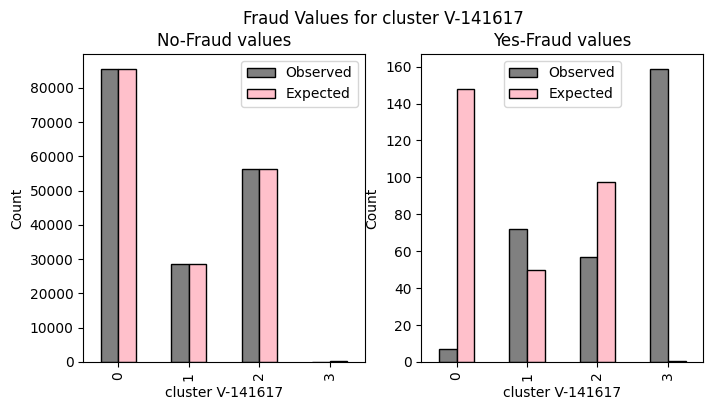

In [5]:
##calls a function tailored for this question and returns the result of each group against fraud to check for proportionality
chi2_target_v_groups(train,target,cluster_list)

### Takeaway
- > all clusters show have an affect on the distribution of Fraud, Cluster V-030409.0, Cluster V-101112.2, and Cluster V_141617.3 will all be good drivers for determining positive fraud

In [6]:
strong_clusters=[(cluster_list[1],0),(cluster_list[2],2),(cluster_list[3],3)]

Let's see if our engineer feature of indicate has significance in mean values related to Fraud
##  **Hypothesis 3 - When divided into Yes-Fraud and No-Fraud, will the mean values of Indicate remain the same?**
> - alpha = .05
> - $H_0$: The mean values of `Indicate` will not be signifcantly different, relating to `Yes-Fraud` and `No-Fraud`.  
 $\mu_{Indicate}$ independent $\mu_{Fraud-class}$  
 
> - $H_a$: Rejection of Null ~~The mean values of `Indicate` will not be signifcantly different, relating to `Yes-Fraud` and `No-Fraud`~~  
~~$\mu_{Indicate}$ independent $\mu_{Fraud-class}$~~

>Conclusion: There is enough evidence to reject our null hypothesis for this case


we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=32563.39703, p=0.00000

 We reject the null Hypothesis ( F̶e̶a̶t̶u̶r̶e̶ ̶E̶n̶g̶i̶n̶e̶e̶r̶e̶d̶ ̶o̶f̶ ̶F̶r̶a̶u̶d̶ ̶i̶s̶ ̶e̶q̶u̶a̶l̶ ̶t̶o̶ ̶F̶e̶a̶t̶u̶r̶e̶ ̶E̶n̶g̶i̶n̶e̶e̶r̶e̶d̶ ̶o̶f̶ ̶N̶o̶t̶ ̶F̶r̶a̶u̶d̶ ) t=7.53924, p=0.00000


<Figure size 1200x600 with 0 Axes>

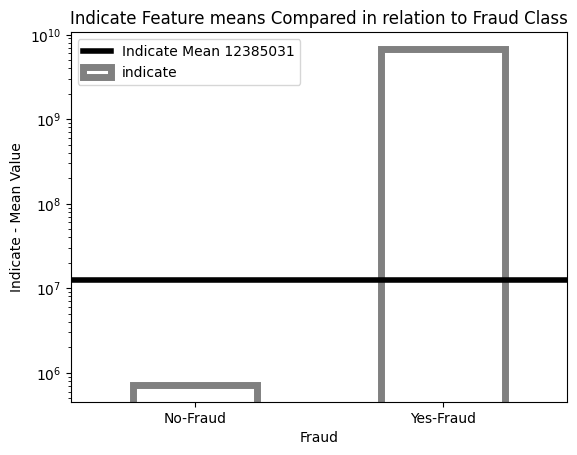

In [7]:
##function tailored for this question, please see documentation for questions
twosample_ttest_for_cc(train)

### Takeaway
- > The `indicate` engineered feature has greatly different means for the each class of `Fraud` this will prove a boon for our modeling

Let's verify our clusters that contained inequal distributions have enough "oomph" to be considered significant
##  **Hypothesis 4 - Are the mean values of Each Cluster equal to each other in relation to Fraud Class**
> - alpha = .05
> - $H_0$: The mean values of `Cluster-Sample_n` will not be signifcantly different from `Cluster-Population` relating `Fraud`.  
> - $H_a$: Rejection of Null ~~The mean values of `Cluster-Sample_n` will not be signifcantly different from `Cluster-Population` relating `Fraud`.~~  
> Conclusion: There is enough evidence to reject our null hypothesis for all cases

Class <-target | cluster V-030409 <-population name | 0 <-sample name
We reject the null Hypothesis ( 0̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶m̶e̶a̶n̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶V̶-̶0̶3̶0̶4̶0̶9̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶F̶r̶a̶u̶d̶ ) t=14.20438, p=0.00000
----------
Class <-target | cluster V-101112 <-population name | 2 <-sample name
We reject the null Hypothesis ( 2̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶m̶e̶a̶n̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶V̶-̶1̶0̶1̶1̶1̶2̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶F̶r̶a̶u̶d̶ ) t=14.60406, p=0.00000
----------
Class <-target | cluster V-141617 <-population name | 3 <-sample name
We reject the null Hypothesis ( 3̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶m̶e̶a̶n̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶V̶-̶1̶4̶1̶6̶1̶7̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶F̶r̶a̶u̶d̶ ) t=31.95457, p=0.00000
----------


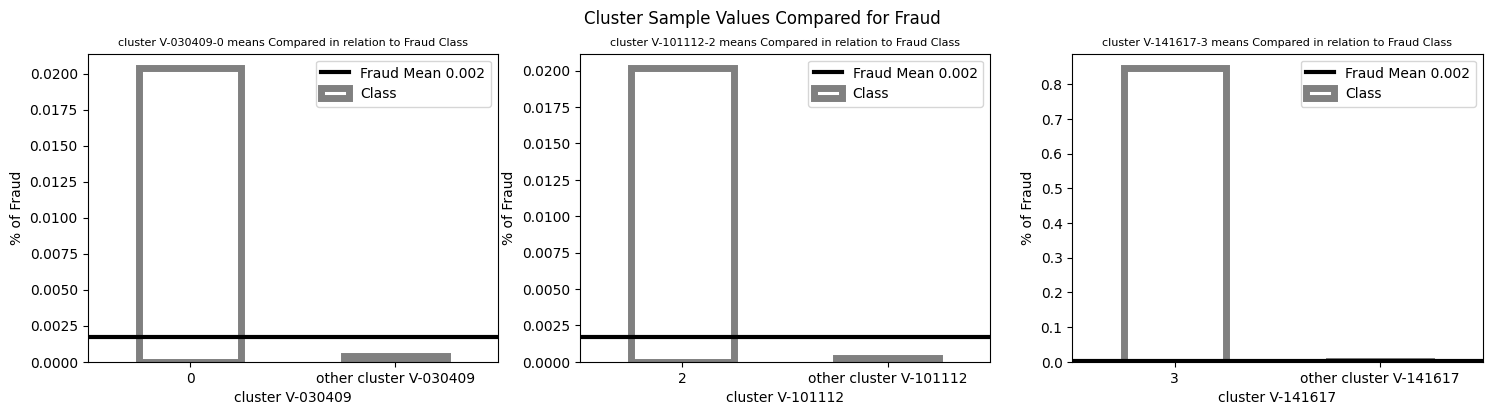

In [8]:
## calls tailored function for testing the clusters idenified as strong against thier population mean to identify significance
sample_to_pop_ttest_strong_clusters(train,strong_clusters)

#### Takeaways
 - Confirms what we saw in the CHI^2 tests (with significance), with an emphasis on `Cluster V141617` as being a strong indicator of Fraud

## Explore Takeaways
 - Feature `V20` hold value in determining Fraud and will be used in modeling
 - Engineer Feature `Indicate` will also be useful in modeling as a way to predict fraud with it's high deviance depending on Fraud Class
 - We have isolated 3 Clusters from our groups that will also provide benefit and will be utilized in modeling
 - Features to direct in our modeling phase: `V20`, `Indicate`, `V141617.3`, `V101112.2`, `V030409.2`

In [9]:
model_feautures=["V20","indicate","V030409_0","V101112_2","V141617_3","if1_anom"]

# Modeling

In [10]:
X_train,y_train,X_validate,y_validate,X_test,y_test = encoding_for_modeling_Xy(train, train_scaled, validate, validate_scaled, test, test_scaled,target,model_feautures)

done


In [11]:
y_pred_val_dt,y_pred_logreg_val,y_pred_rf_val,clf,logreg,rf = modeling_initial(train,target,X_train,y_train,X_validate,y_validate)

0 <--- mode of Class(No-Fraud) in training data / baseline prediction
99.83% <--- accuracy of baseline prediciton in training data
----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       0.92      0.62      0.74        99

    accuracy                           1.00     56962
   macro avg       0.96      0.81      0.87     56962
weighted avg       1.00      1.00      1.00     56962
 	 Decision Tree classification report on validate set
----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       0.86      0.64      0.73        99

    accuracy                           1.00     56962
   macro avg       0.93      0.82      0.87     56962
weighted avg       1.00      1.00      1.00     56962
 	 Logistic Regression validate classification
----------------
              precision    recall  f1-score   support

         

### Takeaways
* During initial testing a lot looks like overfitting due to small size of our target variable
* `0` is set as baseline due to it being the majority of cases (99.83%)
* Only 0.17% of sample is `1` (Yes-Fraud) our target Class
-----------
* After continued testing the my main three classfiers i was able to hypertune the parameters, optimizing for high precision on the validate set
* All models did pretty good at this point, being able to identify 92% of our target variable correctly
-----------
* for additional testing i could resample at a more even rate of the target variable (SMOTE)
-----------
* Models primarily compared via Precision and Recall (F1 score)
* RandomForest was the second best model, coming in under Decision Tree
-----------
* LogReg was decent in it's performance and makes it a strong back-up candidate
* Decision Tree was the best model that i could have faith would not lead to massive overfitting moving forward


## Opting to use DecisionTree for the final test predictions
- almost all the model performances where similar to each other, so I used the one with the fastest to implement/explain

In [13]:
## running the test set using my decision tree classifier
## produces confusion, classifification report as well as probabilities

y_pred_clf_test = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred_clf_test), "confusion matrix")
print('Accuracy of decision tree classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print(round(recall_score(y_test,y_pred_clf_test,average="weighted")*100,2),"% recall")
print(round(precision_score(y_test,y_pred_clf_test,average="weighted")*100,2),"% precision")
print(round(accuracy_score(y_test,y_pred_clf_test)*100,2),"% accuracy")
print("----------")
print(classification_report(y_test, y_pred_clf_test),"\t test classification report")

[[56858     6]
 [   45    53]] confusion matrix
Accuracy of decision tree classifier on test set: 1.00
99.91 % recall
99.9 % precision
99.91 % accuracy
----------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.90      0.54      0.68        98

    accuracy                           1.00     56962
   macro avg       0.95      0.77      0.84     56962
weighted avg       1.00      1.00      1.00     56962
 	 test classification report


### Test model Takeaway
Improves on baseline accuracy by 0.08% (of available 0.17%). Would recommend this model over baseline!

# Conclusion

## Summary of Key Findings
* High level of confidentiality lead to utilizing tools to determine direction rather than Domain Knoweldge
* Clustering creation was able to show difference in `Fraud` prediction
* Feature sets informed by clustering performed best on model through validation phase
    * Best model utilized Clustering and Feature Engineering
* Model gain on predictive performance vs. baseline prediction was minimal on test set
    * Baseline accuracy: 99.83%
    * Test model accuracy: 99.91% (Higher is better) 

## Suggestions and Next Steps
* No suggestions this time as the model barely beats baseline predictions
* Take a look at adding more features into the model to create a more robust predictor
    - The main features we explored would be a good starting point 
* Investigate features highlighted by RFE and see how they perform
* Possible look at reducing variation within features by analyzing significance
    - Identify features were `Fraud` variation was driven by primarly outliers 
* May consider creating different or time specific models
* Take different approach to combining the data
    - Rely more on the raw features rather than feature engineering